# Tutorial 3: Training and Evaluating the CVAE

In this tutorial, we train a Conditional Variational Autoencoder (CVAE) using PyTorch.
We assume the model architecture, loss function, and dataset have already been defined in earlier tutorials.

We will:

Train the CVAE using labeled data

Monitor training and validation loss

Save the best-performing model for later use



In [38]:
from google.colab import drive
drive.mount('/content/drive')

import sys
import os

REPO_PATH = "/content/drive/MyDrive/Colab Notebooks/VAE-Medical-Image-Gen-Tutorial"

# Change directory at the Python level (not IPython magic)
os.chdir(REPO_PATH)

# Add repo root to Python path
if REPO_PATH not in sys.path:
    sys.path.insert(0, REPO_PATH)

# from data.data_setup import setup_chexpert_data
# import importlib
# from data.data_download import setup_colab
# from data.data_download import prepare_chexpert

# importlib.reload(setup_colab)
# importlib.reload(prepare_chexpert)
# from data import data_setup
# importlib.reload(data_setup)
from data.data_setup import setup_chexpert_data

setup_chexpert_data(
    batch_size=50,
    total=2000
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Syncing validation images...
Syncing CSVs...
Syncing training images (batched)...
Found 2000 patient folders. Starting batch copy...

=== Copying batch 1 (0 to 49) ===
patient00002 already exists — skipping
patient00003 already exists — skipping
patient00007 already exists — skipping
patient00008 already exists — skipping
patient00009 already exists — skipping
patient00010 already exists — skipping
patient00011 already exists — skipping
patient00012 already exists — skipping
patient00013 already exists — skipping
patient00014 already exists — skipping
patient00015 already exists — skipping
patient00016 already exists — skipping
patient00017 already exists — skipping
patient00019 already exists — skipping
patient00020 already exists 

## Training Configuration

These are the the main training hyperparameters:

- LATENT_DIM controls the dimensionality of the learned latent space

- LABEL_DIM specifies the size of the conditional input

- LR is the learning rate for the optimizer

- EPOCHS determines how many passes we make over the dataset

- CHECKPOINT_PATH specifies where to save the best model

- LOAD_EXISTING allows us to resume training from a saved checkpoint

In [39]:
LATENT_DIM = 32
LABEL_DIM = 1
LR = 1e-3
EPOCHS = 50
CHECKPOINT_PATH = "/content/drive/MyDrive/cvae_best2.pt"
LOAD_EXISTING = False

## Train

We now bring together the model, optimizer, and data loaders to run the training loop. The code automatically uses a GPU if one is available, otherwise falling back to CPU. If LOAD_EXISTING is enabled, we load a previously saved model checkpoint before training. We obtain training and validation data loaders from the data module defined in earlier tutorials.

For each training epoch, images and labels are moved to the appropriate device, the model produces reconstructions and latent statistics, the CVAE loss is computed and backpropagated, and the model parameters are updated using Adam.

In [48]:
import torch
from model.cvae import CVAE
from model.loss import cvae_loss
from model.eval import evaluate



# delete me
import importlib
from data import data_loader
importlib.reload(data_loader)
from model import eval
importlib.reload(eval)
from model.eval import evaluate

from data.data_loader import get_chexpert_train_dataloader, get_chexpert_valid_dataloader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CVAE(latent_dim=LATENT_DIM, label_dim=LABEL_DIM).to(device)
best_val_loss = float("inf")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if LOAD_EXISTING:
    model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
    print("Loaded existing model")

train_loader = get_chexpert_train_dataloader()
valid_loader = get_chexpert_valid_dataloader()

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        recon, mu, logvar = model(imgs, labels)
        loss = cvae_loss(recon, imgs, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    val_loss = evaluate(model, valid_loader, device)
    valid_losses.append(val_loss)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train: {train_loss:.4f} | Val: {val_loss:.4f}"
    )

    # Checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print("Saved best model")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/50 | Train: 404.7755 | Val: 270.3688
Saved best model


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/50 | Train: 216.3216 | Val: 218.4553
Saved best model


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/50 | Train: 194.3026 | Val: 205.9403
Saved best model
Epoch 4/50 | Train: 184.8687 | Val: 200.9279
Saved best model
Epoch 5/50 | Train: 180.0227 | Val: 199.5169
Saved best model
Epoch 6/50 | Train: 176.8224 | Val: 195.9050
Saved best model
Epoch 7/50 | Train: 174.3954 | Val: 195.0899
Saved best model
Epoch 8/50 | Train: 171.9377 | Val: 192.5492
Saved best model
Epoch 9/50 | Train: 170.0685 | Val: 190.6000
Saved best model
Epoch 10/50 | Train: 168.6051 | Val: 190.1724
Saved best model
Epoch 11/50 | Train: 166.6380 | Val: 191.1976
Epoch 12/50 | Train: 165.3620 | Val: 191.7403
Epoch 13/50 | Train: 163.9503 | Val: 190.0179
Saved best model
Epoch 14/50 | Train: 163.0292 | Val: 189.5670
Saved best model
Epoch 15/50 | Train: 161.8042 | Val: 190.5498
Epoch 16/50 | Train: 160.5010 | Val: 188.9490
Saved best model
Epoch 17/50 | Train: 159.7982 | Val: 189.8442
Epoch 18/50 | Train: 158.7826 | Val: 190.6748
Epoch 19/50 | Train: 157.8281 | Val: 189.2820
Epoch 20/50 | Train: 157.1576 | Val: 1

## Training Loss and Validation Loss per Epoch

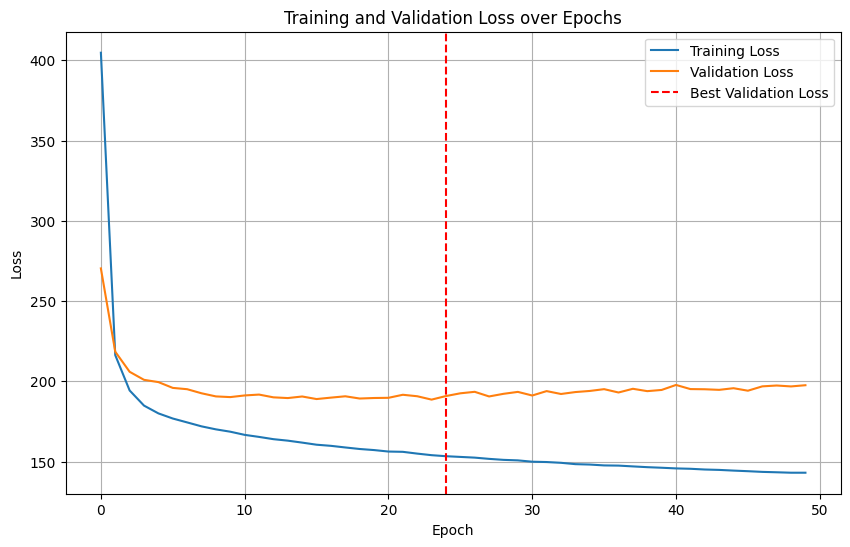

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.axvline(x=24, color='r', linestyle='--', label='Best Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Summary


In this tutorial, we:

- Trained a Conditional Variational Autoencoder using labeled data

- Monitored training and validation loss across epochs

- Saved model checkpoints based on validation performance

In the next tutorial, we will visualize reconstructions and explore how the learned latent space captures meaningful structure in chest X-ray images